In [1]:
import os
import sys
import numpy as np
from PIL import Image
from keras.models import Sequential
from keras.layers import Dropout, Dense, BatchNormalization
from keras.layers import Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop
from keras.optimizers.schedules import ExponentialDecay
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf

from random import shuffle
from glob import glob
import shutil
from shutil import copyfile

In [2]:
# Code for Correcting Error
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


# Define Print Progress Bar Function
def print_progress(iteration, total, prefix='>> Progress:', suffix='Complete', decimals=1, bar_length=55):
    str_format = "{0:." + str(decimals) + "f}"
    current_progress = iteration / float(total)
    percents = str_format.format(100 * current_progress)
    filled_length = int(round(bar_length * current_progress))
    bar = "■" * filled_length + '□' * (bar_length - filled_length)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

1 Physical GPUs, 1 Logical GPUs


In [3]:
def move_data(train_dir, valid_dir, base_dir):
    
    # 1차적으로 모든 데이터를 train_dir로 옮겨준다
    for subdir, dirs, files in os.walk(base_dir):
        if subdir == base_dir:
            continue
           
        fish_type = subdir[len(base_dir):]
        os.makedirs(train_dir + fish_type)
        for file in files:
            copyfile(os.path.join(subdir, file), os.path.join(train_dir + fish_type, file))
        
        print(f'number of files in {subdir[len(base_dir):]} = {len(os.listdir(subdir))}')
    
    # 이후 validation에 사용할 랜덤 데이터를 옮겨준다
    for subdir, dirs, files in os.walk(train_dir):
        if subdir == train_dir:
            continue
        
        valid_files = np.random.choice(files, int(len(os.listdir(subdir)) * 0.3), replace=False)
        
        print(f'number of validation files = {len(valid_files)}')
        
        fish_type = subdir[len(train_dir):]
        os.makedirs(valid_dir + fish_type)
        for file in valid_files:
            shutil.move(os.path.join(subdir, file), os.path.join(valid_dir+fish_type, file))

In [4]:
base_dir = './dataset'
train_dir = './training_data/train/'
valid_dir = './training_data/validate/'

# if directory is empty, copy files
if not os.listdir(train_dir):
    print('start moving data')
    move_data(train_dir, valid_dir, base_dir)
else:
    print('remove data first\n. . .')
    shutil.rmtree(train_dir)
    shutil.rmtree(valid_dir)
    
    os.makedirs(train_dir)
    os.makedirs(valid_dir)
    print('directory emptied. start moving data')
    move_data(train_dir, valid_dir, base_dir)


remove data first
. . .
directory emptied. start moving data
number of files in \catfish_메기 = 87
number of files in \crucian carp_붕어 = 73
number of files in \flatfish_광어 = 62
number of files in \golden mandarin fish_쏘가리 = 51
number of files in \red snapper_참돔 = 70
number of files in \rockfish_우럭 = 53
number of validation files = 26
number of validation files = 21
number of validation files = 18
number of validation files = 15
number of validation files = 21
number of validation files = 15


In [5]:
types = os.listdir(base_dir)
cnt = len(types)

img_height = 112
img_width = 112

In [6]:
# Parsing Images
# # Parsing Training Image
x_train = []
y_train = []

# ## Image Parsing Process
print("\nTraining Image Parsing Started")
for idx, type in enumerate(types):
    print("<" + type + "> Image Parsing Progressing")
    label = [0 for i in range(cnt)]
    label[idx] = 1
    img_dir = train_dir + type + '/'
    for top, folder, file in os.walk(img_dir):
        for filename in file:
            print_progress(file.index(filename) + 1, len(file))
            img = Image.open(img_dir + filename)
            img = img.convert("RGB")
            img = img.resize((img_width, img_height))
            img_data = np.asarray(img)
            x_train.append(img_data/255)
            y_train.append(label)
x_train = np.array(x_train)
y_train = np.array(y_train)
print("Training Image Parsing Finished")


Training Image Parsing Started
<catfish_메기> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<crucian carp_붕어> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<flatfish_광어> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<golden mandarin fish_쏘가리> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<red snapper_참돔> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<rockfish_우럭> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
Training Image Parsing Finished


In [7]:
# # Parsing Validation Image
x_val = []
y_val = []
# ## Image Parsing Process
print("\nValidation Image Parsing Started")
for idx, type in enumerate(types):
    print("<" + type + "> Image Parsing Progressing")
    label = [0 for i in range(cnt)]
    label[idx] = 1
    img_dir = valid_dir + type + '/'
    for top, folder, file in os.walk(img_dir):
        for filename in file:
            print_progress(file.index(filename) + 1, len(file))
            img = Image.open(img_dir + filename)
            img = img.convert("RGB")
            img = img.resize((img_width, img_height))
            img_data = np.asarray(img)
            x_val.append(img_data/255)
            y_val.append(label)
x_val = np.array(x_val)
y_val = np.array(y_val)
print("Validation Image Parsing Finished\n")


Validation Image Parsing Started
<catfish_메기> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<crucian carp_붕어> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<flatfish_광어> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<golden mandarin fish_쏘가리> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<red snapper_참돔> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<rockfish_우럭> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
Validation Image Parsing Finished



In [8]:
# Build CNN Model
Fish_Classifier = Sequential()
# # Feature Extraction Layer
# ## Convolution Layer
Fish_Classifier.add(Conv2D(input_shape=(img_width, img_height, 3), filters=64, kernel_size=(3, 3), strides=(1, 1),
                           padding='same', kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
# ## Pooling Layer (Max Pooling)
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
Fish_Classifier.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
Fish_Classifier.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
Fish_Classifier.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# # Fully-Connected Layer
Fish_Classifier.add(Flatten())
Fish_Classifier.add(Dense(4096, activation='relu'))
Fish_Classifier.add(Dropout(0.5))
Fish_Classifier.add(Dense(4096, activation='relu'))
Fish_Classifier.add(Dropout(0.5))
# ## Output Layer
Fish_Classifier.add(Dense(cnt, activation='softmax'))

In [9]:
# Set Optimizer (RMSprop) and Learning Rate
#lr_decay = ExponentialDecay(initial_learning_rate=0.1, decay_steps=1, decay_rate=0.9)
opt = RMSprop(learning_rate=0.00001)
Fish_Classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

Fish_Classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0

In [10]:
# Set Training Condition
Datetime = datetime.datetime.now().strftime('%m%d_%H%M')
# # Set Saving Path of Trained Model
Check_Pointer = ModelCheckpoint(filepath="improved_model4.h5", monitor='val_loss', verbose=1, save_best_only=True)
Early_Stopping_Callback = EarlyStopping(monitor='val_loss', patience=1000)
# # Train Model
history = Fish_Classifier.fit(x_train, y_train, epochs=1000, batch_size=16, verbose=1, validation_data=(x_val, y_val),
                              callbacks=[Early_Stopping_Callback, Check_Pointer])

Epoch 1/1000
18/18 [==============================] - 13s 356ms/step - loss: 5.3836 - acc: 0.1983 - val_loss: 4.1174 - val_acc: 0.2241

Epoch 00001: val_loss improved from inf to 4.11736, saving model to improved_model4.h5
Epoch 2/1000
18/18 [==============================] - 4s 249ms/step - loss: 4.7925 - acc: 0.2838 - val_loss: 4.1179 - val_acc: 0.2241

Epoch 00002: val_loss did not improve from 4.11736
Epoch 3/1000
18/18 [==============================] - 4s 249ms/step - loss: 4.3593 - acc: 0.4015 - val_loss: 4.1371 - val_acc: 0.2241

Epoch 00003: val_loss did not improve from 4.11736
Epoch 4/1000
18/18 [==============================] - 4s 248ms/step - loss: 3.9178 - acc: 0.4998 - val_loss: 4.1664 - val_acc: 0.2241

Epoch 00004: val_loss did not improve from 4.11736
Epoch 5/1000
18/18 [==============================] - 4s 249ms/step - loss: 3.8315 - acc: 0.4976 - val_loss: 4.2191 - val_acc: 0.2241

Epoch 00005: val_loss did not improve from 4.11736
Epoch 6/1000
18/18 [=============

18/18 [==============================] - 4s 250ms/step - loss: 2.4165 - acc: 0.9650 - val_loss: 3.3459 - val_acc: 0.7414

Epoch 00043: val_loss did not improve from 2.88517
Epoch 44/1000
18/18 [==============================] - 4s 250ms/step - loss: 2.3939 - acc: 0.9728 - val_loss: 3.1378 - val_acc: 0.7155

Epoch 00044: val_loss did not improve from 2.88517
Epoch 45/1000
18/18 [==============================] - 4s 250ms/step - loss: 2.3535 - acc: 0.9860 - val_loss: 2.9341 - val_acc: 0.8190

Epoch 00045: val_loss did not improve from 2.88517
Epoch 46/1000
18/18 [==============================] - 4s 250ms/step - loss: 2.3720 - acc: 0.9809 - val_loss: 3.5864 - val_acc: 0.7155

Epoch 00046: val_loss did not improve from 2.88517
Epoch 47/1000
18/18 [==============================] - 5s 258ms/step - loss: 2.3602 - acc: 0.9939 - val_loss: 3.2795 - val_acc: 0.7155

Epoch 00047: val_loss did not improve from 2.88517
Epoch 48/1000
18/18 [==============================] - 5s 258ms/step - loss: 2.


Epoch 00086: val_loss did not improve from 2.85526
Epoch 87/1000
18/18 [==============================] - 5s 258ms/step - loss: 2.3488 - acc: 0.9883 - val_loss: 3.0944 - val_acc: 0.7586

Epoch 00087: val_loss did not improve from 2.85526
Epoch 88/1000
18/18 [==============================] - 5s 257ms/step - loss: 2.3535 - acc: 0.9881 - val_loss: 3.1534 - val_acc: 0.8534

Epoch 00088: val_loss did not improve from 2.85526
Epoch 89/1000
18/18 [==============================] - 5s 258ms/step - loss: 2.3043 - acc: 1.0000 - val_loss: 3.1439 - val_acc: 0.8190

Epoch 00089: val_loss did not improve from 2.85526
Epoch 90/1000
18/18 [==============================] - 5s 258ms/step - loss: 2.3072 - acc: 0.9988 - val_loss: 3.1021 - val_acc: 0.8190

Epoch 00090: val_loss did not improve from 2.85526
Epoch 91/1000
18/18 [==============================] - 5s 258ms/step - loss: 2.3138 - acc: 0.9982 - val_loss: 3.3504 - val_acc: 0.7845

Epoch 00091: val_loss did not improve from 2.85526
Epoch 92/1000

18/18 [==============================] - 5s 259ms/step - loss: 2.2585 - acc: 1.0000 - val_loss: 3.1313 - val_acc: 0.8017

Epoch 00130: val_loss did not improve from 2.85526
Epoch 131/1000
18/18 [==============================] - 5s 258ms/step - loss: 2.2575 - acc: 1.0000 - val_loss: 3.0651 - val_acc: 0.8362

Epoch 00131: val_loss did not improve from 2.85526
Epoch 132/1000
18/18 [==============================] - 5s 259ms/step - loss: 2.2603 - acc: 0.9952 - val_loss: 3.0739 - val_acc: 0.8276

Epoch 00132: val_loss did not improve from 2.85526
Epoch 133/1000
18/18 [==============================] - 5s 258ms/step - loss: 2.2524 - acc: 1.0000 - val_loss: 2.9200 - val_acc: 0.8448

Epoch 00133: val_loss did not improve from 2.85526
Epoch 134/1000
18/18 [==============================] - 5s 259ms/step - loss: 2.2582 - acc: 0.9932 - val_loss: 2.9877 - val_acc: 0.8190

Epoch 00134: val_loss did not improve from 2.85526
Epoch 135/1000
18/18 [==============================] - 5s 258ms/step - los


Epoch 00173: val_loss did not improve from 2.85526
Epoch 174/1000
18/18 [==============================] - 5s 257ms/step - loss: 2.1527 - acc: 1.0000 - val_loss: 3.0848 - val_acc: 0.8534

Epoch 00174: val_loss did not improve from 2.85526
Epoch 175/1000
18/18 [==============================] - 5s 257ms/step - loss: 2.1511 - acc: 1.0000 - val_loss: 3.0586 - val_acc: 0.8190

Epoch 00175: val_loss did not improve from 2.85526
Epoch 176/1000
18/18 [==============================] - 5s 258ms/step - loss: 2.1489 - acc: 1.0000 - val_loss: 3.1652 - val_acc: 0.8362

Epoch 00176: val_loss did not improve from 2.85526
Epoch 177/1000
18/18 [==============================] - 5s 258ms/step - loss: 2.1473 - acc: 0.9988 - val_loss: 3.3905 - val_acc: 0.8017

Epoch 00177: val_loss did not improve from 2.85526
Epoch 178/1000
18/18 [==============================] - 5s 259ms/step - loss: 2.1453 - acc: 0.9994 - val_loss: 3.1161 - val_acc: 0.8190

Epoch 00178: val_loss did not improve from 2.85526
Epoch 17

18/18 [==============================] - 4s 232ms/step - loss: 1.9924 - acc: 1.0000 - val_loss: 3.0251 - val_acc: 0.8362

Epoch 00217: val_loss did not improve from 2.82561
Epoch 218/1000
18/18 [==============================] - 4s 228ms/step - loss: 1.9911 - acc: 1.0000 - val_loss: 3.2653 - val_acc: 0.7672

Epoch 00218: val_loss did not improve from 2.82561
Epoch 219/1000
18/18 [==============================] - 4s 230ms/step - loss: 1.9999 - acc: 0.9958 - val_loss: 2.7097 - val_acc: 0.8190

Epoch 00219: val_loss improved from 2.82561 to 2.70971, saving model to improved_model4.h5
Epoch 220/1000
18/18 [==============================] - 4s 226ms/step - loss: 1.9854 - acc: 1.0000 - val_loss: 2.8722 - val_acc: 0.7845

Epoch 00220: val_loss did not improve from 2.70971
Epoch 221/1000
18/18 [==============================] - 4s 223ms/step - loss: 1.9834 - acc: 1.0000 - val_loss: 2.8753 - val_acc: 0.7931

Epoch 00221: val_loss did not improve from 2.70971
Epoch 222/1000
18/18 [=============

18/18 [==============================] - 4s 222ms/step - loss: 1.8307 - acc: 0.9979 - val_loss: 3.1352 - val_acc: 0.8276

Epoch 00260: val_loss did not improve from 2.67208
Epoch 261/1000
18/18 [==============================] - 4s 222ms/step - loss: 1.8213 - acc: 0.9973 - val_loss: 2.7834 - val_acc: 0.8534

Epoch 00261: val_loss did not improve from 2.67208
Epoch 262/1000
18/18 [==============================] - 4s 222ms/step - loss: 1.8171 - acc: 1.0000 - val_loss: 2.8491 - val_acc: 0.8534

Epoch 00262: val_loss did not improve from 2.67208
Epoch 263/1000
18/18 [==============================] - 4s 223ms/step - loss: 1.8154 - acc: 1.0000 - val_loss: 2.7579 - val_acc: 0.8448

Epoch 00263: val_loss did not improve from 2.67208
Epoch 264/1000
18/18 [==============================] - 4s 223ms/step - loss: 1.8114 - acc: 1.0000 - val_loss: 2.8969 - val_acc: 0.8448

Epoch 00264: val_loss did not improve from 2.67208
Epoch 265/1000
18/18 [==============================] - 4s 223ms/step - los

18/18 [==============================] - 4s 223ms/step - loss: 1.5605 - acc: 1.0000 - val_loss: 2.6259 - val_acc: 0.8276

Epoch 00303: val_loss did not improve from 2.42698
Epoch 304/1000
18/18 [==============================] - 4s 224ms/step - loss: 1.5604 - acc: 1.0000 - val_loss: 2.4245 - val_acc: 0.8621

Epoch 00304: val_loss improved from 2.42698 to 2.42448, saving model to improved_model4.h5
Epoch 305/1000
18/18 [==============================] - 4s 223ms/step - loss: 1.5576 - acc: 1.0000 - val_loss: 2.4131 - val_acc: 0.8621

Epoch 00305: val_loss improved from 2.42448 to 2.41305, saving model to improved_model4.h5
Epoch 306/1000
18/18 [==============================] - 4s 225ms/step - loss: 1.5530 - acc: 1.0000 - val_loss: 2.4587 - val_acc: 0.8448

Epoch 00306: val_loss did not improve from 2.41305
Epoch 307/1000
18/18 [==============================] - 4s 223ms/step - loss: 1.5467 - acc: 1.0000 - val_loss: 2.4069 - val_acc: 0.8362

Epoch 00307: val_loss improved from 2.41305 to

18/18 [==============================] - 4s 223ms/step - loss: 1.3077 - acc: 1.0000 - val_loss: 2.3413 - val_acc: 0.8448

Epoch 00345: val_loss did not improve from 2.01534
Epoch 346/1000
18/18 [==============================] - 4s 225ms/step - loss: 1.3027 - acc: 1.0000 - val_loss: 2.3093 - val_acc: 0.8448

Epoch 00346: val_loss did not improve from 2.01534
Epoch 347/1000
18/18 [==============================] - 4s 230ms/step - loss: 1.2969 - acc: 1.0000 - val_loss: 2.1688 - val_acc: 0.8362

Epoch 00347: val_loss did not improve from 2.01534
Epoch 348/1000
18/18 [==============================] - 4s 236ms/step - loss: 1.2951 - acc: 1.0000 - val_loss: 2.4447 - val_acc: 0.8362

Epoch 00348: val_loss did not improve from 2.01534
Epoch 349/1000
18/18 [==============================] - 4s 233ms/step - loss: 1.2915 - acc: 1.0000 - val_loss: 2.4588 - val_acc: 0.8103

Epoch 00349: val_loss did not improve from 2.01534
Epoch 350/1000
18/18 [==============================] - 4s 223ms/step - los

18/18 [==============================] - 4s 228ms/step - loss: 1.0290 - acc: 1.0000 - val_loss: 2.1904 - val_acc: 0.8276

Epoch 00387: val_loss did not improve from 1.72090
Epoch 388/1000
18/18 [==============================] - 4s 228ms/step - loss: 1.0267 - acc: 1.0000 - val_loss: 2.7372 - val_acc: 0.8276

Epoch 00388: val_loss did not improve from 1.72090
Epoch 389/1000
18/18 [==============================] - 4s 228ms/step - loss: 1.0231 - acc: 0.9994 - val_loss: 2.2746 - val_acc: 0.8448

Epoch 00389: val_loss did not improve from 1.72090
Epoch 390/1000
18/18 [==============================] - 4s 228ms/step - loss: 1.0200 - acc: 1.0000 - val_loss: 2.0639 - val_acc: 0.8448

Epoch 00390: val_loss did not improve from 1.72090
Epoch 391/1000
18/18 [==============================] - 4s 227ms/step - loss: 1.0190 - acc: 1.0000 - val_loss: 2.3335 - val_acc: 0.8534

Epoch 00391: val_loss did not improve from 1.72090
Epoch 392/1000
18/18 [==============================] - 4s 226ms/step - los


Epoch 00430: val_loss did not improve from 1.72090
Epoch 431/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.8892 - acc: 1.0000 - val_loss: 2.0300 - val_acc: 0.8190

Epoch 00431: val_loss did not improve from 1.72090
Epoch 432/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.8701 - acc: 1.0000 - val_loss: 1.7146 - val_acc: 0.8534

Epoch 00432: val_loss improved from 1.72090 to 1.71464, saving model to improved_model4.h5
Epoch 433/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.8595 - acc: 1.0000 - val_loss: 2.2722 - val_acc: 0.8017

Epoch 00433: val_loss did not improve from 1.71464
Epoch 434/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.8539 - acc: 1.0000 - val_loss: 2.2907 - val_acc: 0.8103

Epoch 00434: val_loss did not improve from 1.71464
Epoch 435/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.8532 - acc: 1.0000 - val_loss: 2.1403 - val_acc: 0.8534

Epoch 00435: val_lo

18/18 [==============================] - 4s 223ms/step - loss: 0.7461 - acc: 1.0000 - val_loss: 1.9364 - val_acc: 0.8793

Epoch 00474: val_loss did not improve from 1.71464
Epoch 475/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.7415 - acc: 1.0000 - val_loss: 1.9412 - val_acc: 0.8534

Epoch 00475: val_loss did not improve from 1.71464
Epoch 476/1000
18/18 [==============================] - 4s 228ms/step - loss: 0.7404 - acc: 1.0000 - val_loss: 2.0867 - val_acc: 0.8448

Epoch 00476: val_loss did not improve from 1.71464
Epoch 477/1000
18/18 [==============================] - 4s 229ms/step - loss: 0.7382 - acc: 1.0000 - val_loss: 2.3982 - val_acc: 0.8276

Epoch 00477: val_loss did not improve from 1.71464
Epoch 478/1000
18/18 [==============================] - 4s 227ms/step - loss: 0.7352 - acc: 1.0000 - val_loss: 2.5251 - val_acc: 0.8190

Epoch 00478: val_loss did not improve from 1.71464
Epoch 479/1000
18/18 [==============================] - 4s 230ms/step - los

18/18 [==============================] - 4s 221ms/step - loss: 0.6699 - acc: 1.0000 - val_loss: 1.9978 - val_acc: 0.8534

Epoch 00517: val_loss did not improve from 1.71365
Epoch 518/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.6692 - acc: 1.0000 - val_loss: 2.1213 - val_acc: 0.8448

Epoch 00518: val_loss did not improve from 1.71365
Epoch 519/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.6675 - acc: 1.0000 - val_loss: 2.0637 - val_acc: 0.8448

Epoch 00519: val_loss did not improve from 1.71365
Epoch 520/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.6636 - acc: 1.0000 - val_loss: 1.9626 - val_acc: 0.8448

Epoch 00520: val_loss did not improve from 1.71365
Epoch 521/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.6564 - acc: 1.0000 - val_loss: 1.9060 - val_acc: 0.8707

Epoch 00521: val_loss did not improve from 1.71365
Epoch 522/1000
18/18 [==============================] - 4s 222ms/step - los

18/18 [==============================] - 4s 223ms/step - loss: 0.5757 - acc: 1.0000 - val_loss: 1.8723 - val_acc: 0.8793

Epoch 00560: val_loss did not improve from 1.54461
Epoch 561/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.5750 - acc: 1.0000 - val_loss: 1.8895 - val_acc: 0.8707

Epoch 00561: val_loss did not improve from 1.54461
Epoch 562/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.5732 - acc: 1.0000 - val_loss: 1.8042 - val_acc: 0.8879

Epoch 00562: val_loss did not improve from 1.54461
Epoch 563/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.5693 - acc: 1.0000 - val_loss: 1.8763 - val_acc: 0.8707

Epoch 00563: val_loss did not improve from 1.54461
Epoch 564/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.5625 - acc: 1.0000 - val_loss: 1.7129 - val_acc: 0.8793

Epoch 00564: val_loss did not improve from 1.54461
Epoch 565/1000
18/18 [==============================] - 4s 222ms/step - los

18/18 [==============================] - 4s 221ms/step - loss: 0.4666 - acc: 1.0000 - val_loss: 1.6008 - val_acc: 0.8534

Epoch 00603: val_loss did not improve from 1.36838
Epoch 604/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.4665 - acc: 1.0000 - val_loss: 1.6494 - val_acc: 0.8448

Epoch 00604: val_loss did not improve from 1.36838
Epoch 605/1000
18/18 [==============================] - 4s 220ms/step - loss: 0.4675 - acc: 0.9994 - val_loss: 2.1758 - val_acc: 0.7845

Epoch 00605: val_loss did not improve from 1.36838
Epoch 606/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.4649 - acc: 1.0000 - val_loss: 1.6095 - val_acc: 0.8534

Epoch 00606: val_loss did not improve from 1.36838
Epoch 607/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.4649 - acc: 1.0000 - val_loss: 2.1785 - val_acc: 0.8448

Epoch 00607: val_loss did not improve from 1.36838
Epoch 608/1000
18/18 [==============================] - 4s 221ms/step - los

18/18 [==============================] - 4s 221ms/step - loss: 0.3586 - acc: 1.0000 - val_loss: 1.6503 - val_acc: 0.8621

Epoch 00646: val_loss did not improve from 1.21700
Epoch 647/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.3581 - acc: 1.0000 - val_loss: 1.6380 - val_acc: 0.8534

Epoch 00647: val_loss did not improve from 1.21700
Epoch 648/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.3763 - acc: 0.9941 - val_loss: 2.3456 - val_acc: 0.8276

Epoch 00648: val_loss did not improve from 1.21700
Epoch 649/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.3568 - acc: 1.0000 - val_loss: 2.0517 - val_acc: 0.8362

Epoch 00649: val_loss did not improve from 1.21700
Epoch 650/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.3573 - acc: 1.0000 - val_loss: 1.7268 - val_acc: 0.8362

Epoch 00650: val_loss did not improve from 1.21700
Epoch 651/1000
18/18 [==============================] - 4s 222ms/step - los


Epoch 00689: val_loss did not improve from 1.21700
Epoch 690/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.3467 - acc: 1.0000 - val_loss: 1.8025 - val_acc: 0.8707

Epoch 00690: val_loss did not improve from 1.21700
Epoch 691/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.3439 - acc: 1.0000 - val_loss: 1.7120 - val_acc: 0.8621

Epoch 00691: val_loss did not improve from 1.21700
Epoch 692/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.3654 - acc: 0.9856 - val_loss: 1.7352 - val_acc: 0.7931

Epoch 00692: val_loss did not improve from 1.21700
Epoch 693/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.3402 - acc: 1.0000 - val_loss: 1.7160 - val_acc: 0.8017

Epoch 00693: val_loss did not improve from 1.21700
Epoch 694/1000
18/18 [==============================] - 4s 227ms/step - loss: 0.3401 - acc: 1.0000 - val_loss: 1.6718 - val_acc: 0.8017

Epoch 00694: val_loss did not improve from 1.21700
Epoch 69

18/18 [==============================] - 4s 222ms/step - loss: 0.3298 - acc: 0.9992 - val_loss: 2.6348 - val_acc: 0.8190

Epoch 00733: val_loss did not improve from 1.21700
Epoch 734/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.3285 - acc: 1.0000 - val_loss: 2.4813 - val_acc: 0.8190

Epoch 00734: val_loss did not improve from 1.21700
Epoch 735/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.3321 - acc: 1.0000 - val_loss: 2.4013 - val_acc: 0.8103

Epoch 00735: val_loss did not improve from 1.21700
Epoch 736/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.3284 - acc: 1.0000 - val_loss: 2.3312 - val_acc: 0.8103

Epoch 00736: val_loss did not improve from 1.21700
Epoch 737/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.3283 - acc: 1.0000 - val_loss: 2.1256 - val_acc: 0.8190

Epoch 00737: val_loss did not improve from 1.21700
Epoch 738/1000
18/18 [==============================] - 4s 222ms/step - los


Epoch 00776: val_loss did not improve from 1.21700
Epoch 777/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.2896 - acc: 1.0000 - val_loss: 1.4603 - val_acc: 0.8621

Epoch 00777: val_loss did not improve from 1.21700
Epoch 778/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2891 - acc: 1.0000 - val_loss: 1.4491 - val_acc: 0.8534

Epoch 00778: val_loss did not improve from 1.21700
Epoch 779/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2990 - acc: 0.9979 - val_loss: 2.7858 - val_acc: 0.7672

Epoch 00779: val_loss did not improve from 1.21700
Epoch 780/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2879 - acc: 1.0000 - val_loss: 2.5297 - val_acc: 0.7759

Epoch 00780: val_loss did not improve from 1.21700
Epoch 781/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.3481 - acc: 0.9916 - val_loss: 1.6526 - val_acc: 0.8276

Epoch 00781: val_loss did not improve from 1.21700
Epoch 78

18/18 [==============================] - 4s 221ms/step - loss: 0.2513 - acc: 1.0000 - val_loss: 1.9044 - val_acc: 0.8448

Epoch 00819: val_loss did not improve from 1.00736
Epoch 820/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.2491 - acc: 1.0000 - val_loss: 1.6199 - val_acc: 0.8362

Epoch 00820: val_loss did not improve from 1.00736
Epoch 821/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2456 - acc: 1.0000 - val_loss: 1.4211 - val_acc: 0.8276

Epoch 00821: val_loss did not improve from 1.00736
Epoch 822/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2400 - acc: 1.0000 - val_loss: 2.5697 - val_acc: 0.7931

Epoch 00822: val_loss did not improve from 1.00736
Epoch 823/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.2351 - acc: 0.9996 - val_loss: 1.8411 - val_acc: 0.7845

Epoch 00823: val_loss did not improve from 1.00736
Epoch 824/1000
18/18 [==============================] - 4s 221ms/step - los


Epoch 00862: val_loss did not improve from 1.00736
Epoch 863/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2105 - acc: 1.0000 - val_loss: 2.5892 - val_acc: 0.8621

Epoch 00863: val_loss did not improve from 1.00736
Epoch 864/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2104 - acc: 1.0000 - val_loss: 2.5092 - val_acc: 0.8534

Epoch 00864: val_loss did not improve from 1.00736
Epoch 865/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2104 - acc: 1.0000 - val_loss: 2.4456 - val_acc: 0.8534

Epoch 00865: val_loss did not improve from 1.00736
Epoch 866/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.2179 - acc: 0.9932 - val_loss: 2.2875 - val_acc: 0.8362

Epoch 00866: val_loss did not improve from 1.00736
Epoch 867/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2102 - acc: 1.0000 - val_loss: 2.1978 - val_acc: 0.8362

Epoch 00867: val_loss did not improve from 1.00736
Epoch 86

18/18 [==============================] - 4s 222ms/step - loss: 0.1841 - acc: 1.0000 - val_loss: 1.4675 - val_acc: 0.8707

Epoch 00906: val_loss did not improve from 0.91057
Epoch 907/1000
18/18 [==============================] - 4s 220ms/step - loss: 0.1821 - acc: 1.0000 - val_loss: 1.3070 - val_acc: 0.8707

Epoch 00907: val_loss did not improve from 0.91057
Epoch 908/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.1784 - acc: 1.0000 - val_loss: 1.0581 - val_acc: 0.8621

Epoch 00908: val_loss did not improve from 0.91057
Epoch 909/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.1742 - acc: 1.0000 - val_loss: 1.4167 - val_acc: 0.7845

Epoch 00909: val_loss did not improve from 0.91057
Epoch 910/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.3724 - acc: 0.9793 - val_loss: 2.2563 - val_acc: 0.7845

Epoch 00910: val_loss did not improve from 0.91057
Epoch 911/1000
18/18 [==============================] - 4s 221ms/step - los


Epoch 00949: val_loss did not improve from 0.91057
Epoch 950/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.1539 - acc: 1.0000 - val_loss: 1.4864 - val_acc: 0.8534

Epoch 00950: val_loss did not improve from 0.91057
Epoch 951/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.1682 - acc: 0.9962 - val_loss: 2.3578 - val_acc: 0.8448

Epoch 00951: val_loss did not improve from 0.91057
Epoch 952/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2001 - acc: 0.9979 - val_loss: 2.0589 - val_acc: 0.8448

Epoch 00952: val_loss did not improve from 0.91057
Epoch 953/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.1538 - acc: 1.0000 - val_loss: 1.9793 - val_acc: 0.8276

Epoch 00953: val_loss did not improve from 0.91057
Epoch 954/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.1538 - acc: 1.0000 - val_loss: 1.9086 - val_acc: 0.8190

Epoch 00954: val_loss did not improve from 0.91057
Epoch 95

18/18 [==============================] - 4s 226ms/step - loss: 0.1517 - acc: 1.0000 - val_loss: 2.8853 - val_acc: 0.8276

Epoch 00993: val_loss did not improve from 0.91057
Epoch 994/1000
18/18 [==============================] - 4s 225ms/step - loss: 0.1513 - acc: 1.0000 - val_loss: 2.6807 - val_acc: 0.8276

Epoch 00994: val_loss did not improve from 0.91057
Epoch 995/1000
18/18 [==============================] - 4s 225ms/step - loss: 0.1504 - acc: 1.0000 - val_loss: 2.1549 - val_acc: 0.8448

Epoch 00995: val_loss did not improve from 0.91057
Epoch 996/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.1486 - acc: 1.0000 - val_loss: 1.9062 - val_acc: 0.8621

Epoch 00996: val_loss did not improve from 0.91057
Epoch 997/1000
18/18 [==============================] - 4s 226ms/step - loss: 0.1456 - acc: 1.0000 - val_loss: 1.1982 - val_acc: 0.8276

Epoch 00997: val_loss did not improve from 0.91057
Epoch 998/1000
18/18 [==============================] - 4s 222ms/step - los

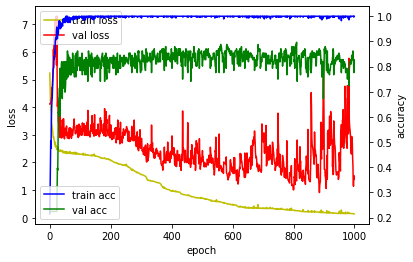

In [11]:
# Visualize Training Process and Result
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()